# Generative Adversarial Nets on MNIST

Created by: Daniel L. Marino (marinodl@vcu.edu)

Description: Implementation of the algorithm shown in Goodfellow et al. "Generative Adversarial Nets" (https://arxiv.org/pdf/1406.2661v1.pdf)



In [1]:
import tensorflow as tf
import numpy as np

from twodlearn.feedforward import *
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. Load MNIST

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

batch_X, batch_y = mnist.train.next_batch(100)

print(batch_X.shape)
print(np.reshape(batch_X, [-1,28,28,1]).shape)
print(batch_y.shape)
print(np.max(batch_X), np.min(batch_X))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(100, 784)
(100, 28, 28, 1)
(100, 10)
1.0 0.0


## 2. Model definition

In [3]:
config = tf.ConfigProto()
#config.gpu_options.allow_growth=True

sess = tf.InteractiveSession(config=config)

#### Discriminative model

In [4]:
x_size = batch_X.shape[-1];
z_size = 100
d_hidden = [240, 240]

# Define MLP Net
d_net= MlpNet( x_size, 1, d_hidden, afunction= tf.nn.relu ,name='DNet')

#### Generative model

In [5]:
g_hidden = [1000, 1000]

# Define MLP Net
g_net= MlpNet( z_size, x_size, g_hidden, afunction= tf.nn.relu ,name='GNet')

In [6]:
'''
varlist = tf.trainable_variables()

print(len(varlist))
print(varlist[0].name )
print(varlist[1].name )
print('GNet' in varlist[1].name )

g_trainable = [ w for w in tf.trainable_variables() if 'GNet' in w.name]
print(len(g_trainable))

print(g_trainable[0].name)
'''

"\nvarlist = tf.trainable_variables()\n\nprint(len(varlist))\nprint(varlist[0].name )\nprint(varlist[1].name )\nprint('GNet' in varlist[1].name )\n\ng_trainable = [ w for w in tf.trainable_variables() if 'GNet' in w.name]\nprint(len(g_trainable))\n\nprint(g_trainable[0].name)\n"

### 2.1. loss functions

In [7]:
m = 600;
batch_size_traing = m;
batch_size_traind = 2*m;

drop_prob_d = tf.placeholder(tf.float32)
drop_prob_g = tf.placeholder(tf.float32)

''' 1. For the discriminative loss '''
g_traind = g_net.setup( m );
d_traind = d_net.setup( batch_size_traind, drop_prob_d, loss_type= 'cross_entropy' );

traind_loss = d_traind.loss;
# Optimizer.
d_trainable = [ w for w in tf.trainable_variables() if 'DNet' in w.name]


#d_opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)
d_opt = tf.train.MomentumOptimizer(learning_rate=0.1, momentum= 0.5)
d_optimizer = d_opt.minimize(traind_loss, var_list= d_trainable)
#d_optimizer = tf.train.AdamOptimizer(0.0005).minimize(dtrain_loss, var_list = d_trainable) #0.001

''' 2. For the generative loss '''
g_traing = g_net.setup(batch_size_traing);
d_traing = d_net.setup(batch_size_traing, drop_prob_d, inputs= tf.sigmoid(g_traing.y), loss_type= 'cross_entropy');

traing_loss = d_traing.loss;

# Optimizer.
g_trainable = [ w for w in tf.trainable_variables() if 'GNet' in w.name]

#g_opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)
g_opt = tf.train.MomentumOptimizer(learning_rate=0.1, momentum= 0.5)
g_optimizer = g_opt.minimize(traing_loss, var_list= g_trainable)

# for generating data
gen_model = tf.sigmoid(g_traind.y)

## 3. Train the model

In [8]:
def random_generator(n_samples, n_dim):
    return 2.0*(np.random.rand(n_samples, n_dim) - 0.5)

def data_generator(n_samples, noise_p= None):
    batch_x, _= mnist.train.next_batch(n_samples) # images values are normalized between 0-1
    
    if noise_p is None:
        return batch_x
        
    else:
        rand_x = np.random.rand(*batch_x.shape) # random noise values are between 0-1
        
        return (1-noise_p)*batch_x + noise_p*rand_x;
        


In [9]:
num_steps = 40000 #2000
k_steps = 1
n_logging = 100

tf.global_variables_initializer().run()
print('Initialized')


g_loss= 0
d_loss= 0
for step in range(num_steps):
    # ------- optimize discriminator -------
    for k in range(k_steps):
        # get samples from the generator
        batch_z = random_generator(m, z_size)
        [batch_gz] = sess.run([gen_model], feed_dict= {g_traind.inputs : batch_z, drop_prob_g : 1.0})
        
        # get samples from data
        noise_p = 0.8*math.exp(-0.0001*step); # noise percentage
        batch_x = data_generator(m, noise_p)
        
        # concatenate samples
        batch_x_z= np.concatenate((batch_x, batch_gz), axis=0)
        batch_y= np.concatenate((np.ones((m,1)), np.zeros((m,1))), axis=0)        
        
        # run gradient descent to train the discriminator
        feed_dict = {d_traind.inputs : batch_x_z, d_traind.labels : batch_y, drop_prob_d : 1.0}
        
        _, l = sess.run([d_optimizer, traind_loss],feed_dict=feed_dict)
        d_loss += l
    
    # ------- optimize generator --------
    
    # get noise samples
    batch_z = random_generator(m, z_size)
    
    # run gradient descent to train the generator
    feed_dict = {g_traing.inputs: batch_z, d_traing.labels: np.ones((m,1)), drop_prob_d: 1.0, drop_prob_g: 1.0}
    
    _, l = sess.run([g_optimizer, traing_loss],feed_dict=feed_dict)        
        
    g_loss += l
    
    #  ------- logging -------
    
    if step%n_logging == 0:
        print( step, ' | d_loss:', d_loss/(n_logging*k_steps), ' | g_loss:', g_loss/n_logging, ' | noise_p:', noise_p )
        d_loss = 0
        g_loss = 0

Initialized
0  | d_loss: 0.00695377528667  | g_loss: 0.00709514975548  | noise_p: 0.8
100  | d_loss: 0.638210971951  | g_loss: 0.904740842581  | noise_p: 0.7920398669993345
200  | d_loss: 0.665301110744  | g_loss: 0.774001003504  | noise_p: 0.7841589386454042
300  | d_loss: 0.665672712326  | g_loss: 0.762062779665  | noise_p: 0.7763564268388066
400  | d_loss: 0.72319217205  | g_loss: 0.605882829428  | noise_p: 0.7686315513218586
500  | d_loss: 0.673400421143  | g_loss: 0.661391592324  | noise_p: 0.7609835396005713
600  | d_loss: 0.689746076465  | g_loss: 0.7065415591  | noise_p: 0.753411626867399
700  | d_loss: 0.688051847816  | g_loss: 0.71624822557  | noise_p: 0.7459150559247587
800  | d_loss: 0.67925362885  | g_loss: 0.724460701346  | noise_p: 0.7384930771093087
900  | d_loss: 0.670691596866  | g_loss: 0.725115529895  | noise_p: 0.7311449482169826
1000  | d_loss: 0.673077796102  | g_loss: 0.748216623962  | noise_p: 0.7238699344287677
1100  | d_loss: 0.664562705159  | g_loss: 0.77021

# Generate some samples


0.9999995288
2.94751743203e-08


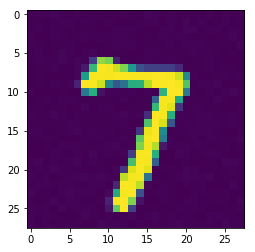

In [30]:
%matplotlib inline

# real
noise_p = 0.7*math.exp(-0.0001*num_steps*1.0);
batch_x = data_generator(m, noise_p)
batch_x = np.reshape(batch_x, [-1,28,28,1])

print(np.max(batch_x))
print(np.min(batch_x))

imgplot = plt.imshow(batch_x[1,:,:,0])



In [11]:
# generated
batch_z = batch_z = random_generator(m, z_size)
[batch_gz] = sess.run([gen_model], feed_dict= {g_traind.inputs : batch_z})
#[batch_gz] = sess.run([g_traind.y], feed_dict= {g_traind.inputs : batch_z})


In [12]:
#print(batch_z[1,:])
#print(batch_z[30,:])
#print('--------------')
#print(batch_gz[1,:])
#print(batch_gz[30,:])


print(batch_gz.shape)
idx= 0

(600, 784)


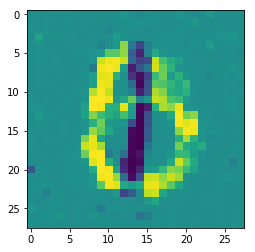

In [13]:
batch_gz = np.reshape(batch_gz, [-1,28,28,1])

#print(batch_gz[0,:,:,0])
imgplot = plt.imshow(batch_gz[idx,:,:,0]-batch_gz[idx+1,:,:,0])
idx +=1

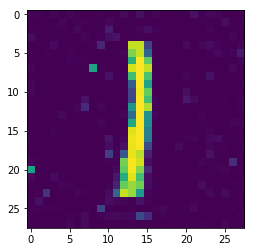

In [14]:
imgplot = plt.imshow(batch_gz[idx,:,:,0])
idx = idx+1